In [1]:
import math
import os
import re

import numpy as np

from skimage import img_as_float, io
from skimage.color import *
from skimage.restoration import denoise_tv_chambolle
from sklearn import svm, metrics

# Files are named whatever-actualCaptchaTyped.png
confirmed_images_re = re.compile(r'-([a-zA-Z0-9]{6})\.png$')

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

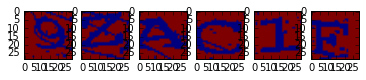

In [3]:
def load_image(path):
    img = img_as_float(rgb2gray(io.imread(path)))[9:38,10:177]
    img[img != 0] = 1
    return img

def get_letters(img, number=6, avg_size=29):
    for i in range(number):
        start = i * avg_size
        nimg = img.copy()[:,start:start + avg_size]
        width_difference = avg_size - nimg.shape[1]
        if width_difference != 0:
            nimg = np.append(nimg, np.ones((nimg.shape[0], width_difference)), axis=1)
        yield nimg

not_trained_captcha = load_image('captchas/captcha-54f0d97919921-9ZAC1F.png')
fig, ax = plt.subplots(ncols=6)

for i, letter in enumerate(get_letters(not_trained_captcha)):
    ax[i].imshow(letter)

In [4]:
imgs = []
limit_images = 30000
total_to_train = int(limit_images * 0.8)
loaded_images = 0
for filename in os.listdir('captchas'):
    match = confirmed_images_re.search(filename)
    if not match:
        continue
    try:
        imgs.append((match.group(1).lower(), load_image('captchas/{}'.format(filename))))
    except (IndexError, OSError):  # Pillow and its errors
        continue
    loaded_images += 1
    if loaded_images == limit_images:
        break
print('{} images'.format(len(imgs)))
letters_image = []
letters_ascii = []
for image in imgs:
    letters, image = image
    for column, letter_image in enumerate(get_letters(image)):
        letters_image.append(letter_image.flatten())
        letters_ascii.append(letters[column])

30000 images


In [5]:
model = svm.SVC(C=10, gamma=0.001, probability=False)
model.fit(letters_image[:total_to_train], letters_ascii[:total_to_train])

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [6]:
predicted = model.predict(letters_image[total_to_train:])
expected = letters_ascii[total_to_train:]
print(metrics.classification_report(expected, predicted))

             precision    recall  f1-score   support

          0       0.66      0.75      0.70      1296
          1       0.81      0.87      0.84      4128
          2       0.94      0.95      0.95      4518
          3       0.92      0.93      0.93      4420
          4       0.96      0.98      0.97      4499
          5       0.94      0.93      0.94      4271
          6       0.90      0.94      0.92      4532
          7       0.97      0.96      0.96      4578
          8       0.87      0.90      0.88      4476
          9       0.93      0.94      0.93      4593
          a       0.98      0.97      0.97      4481
          b       0.80      0.88      0.84      4339
          c       0.93      0.89      0.91      4495
          d       0.88      0.89      0.89      4548
          e       0.90      0.90      0.90      4397
          f       0.88      0.90      0.89      4359
          g       0.89      0.90      0.90      4356
          h       0.94      0.90      0.92   

In [7]:
def decode_captcha(filename, func=None):
    func = func or model.predict
    return func([l.flatten() for l in get_letters(load_image(filename))])

filename = 'captchas/{}'.format(np.random.choice(os.listdir('captchas/')))
print(filename, ''.join(decode_captcha(filename, mo0del.predict)))

captchas/captcha-54f0d89a91c67-OFUS8R.png 0fus8r


In [10]:
from sklearn.grid_search import GridSearchCV
params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                    'C': [1, 10, 100, 1000]},
                   {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
   
clf = GridSearchCV(svm.SVC(), params, n_jobs=1)
# Use this to get the best params for the model
# clf.fit(letters_image[:total_to_train], letters_ascii[:total_to_train])

In [14]:
print(clf.best_estimator_)
clf.grid_scores_

In [15]:
%timeit decode_captcha('captchas/captcha-54f0d99253782-wh4ow7.png')

10 loops, best of 3: 162 ms per loop
